In [1]:
import apgpy as apg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/anaconda3/envs/SHWT/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Generate some data

In [2]:
n = 1000
d = 250
mu = 0.1
x_n = -0.1 * np.random.rand(d)
x_p = 0.1 * np.random.rand(d)
X_p = 5 * np.random.randn(d, n) + np.tile(x_p, (n, 1)).T
X_n = 5 * np.random.randn(d, n) + np.tile(x_n, (n, 1)).T
X = np.hstack((X_p, -X_n))

Define gradient operator

In [3]:
def log_reg_grad(y):
    v = np.exp(-np.dot(X.T, y))
    return np.dot(X, 1 / (1 + v) / 2 / n)

Define proximal operator

In [4]:
def soft_thresh(y, t):
    return np.sign(y) * np.maximum(abs(y) - t * mu, 0)

Solve!

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.38e-01
iter num 35, norm(Gk)/(1+norm(xk)): 7.38e-13, step-size: 7.78e-02
terminated


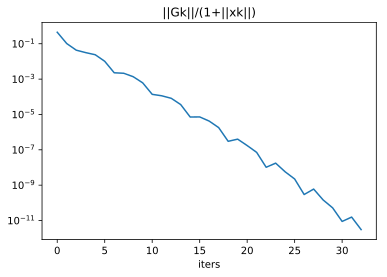

In [5]:
x = apg.solve(log_reg_grad, soft_thresh, np.zeros(d), eps = 1e-12, gen_plots=True)

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.38e-01
iter num 44, norm(Gk)/(1+norm(xk)): 6.85e-13, step-size: 1.03e-01
terminated


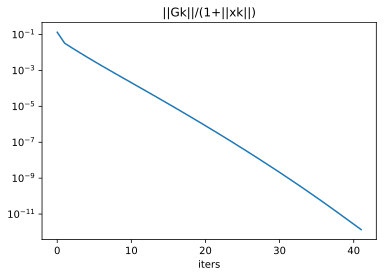

In [6]:
x_no_accleration = apg.solve(log_reg_grad, soft_thresh, np.zeros(d), use_gra=True, eps = 1e-12, gen_plots=True)

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.38e-01
iter num 74, norm(Gk)/(1+norm(xk)): 7.00e-13, step-size: 1.00e-01
terminated


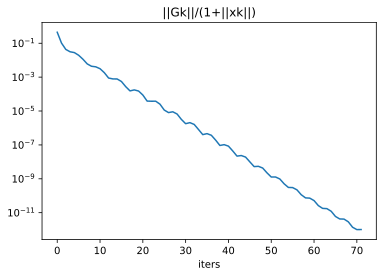

In [7]:
x_no_restart = apg.solve(log_reg_grad, soft_thresh, np.zeros(d), use_restart = False, eps = 1e-12, gen_plots=True)

Compare to ECOS (second order solver) and SCS (another first-order solver):

In [8]:
import cvxpy as cp

print(sum(cp.log_sum_exp(cp.vstack(0, np.dot(X[:, i].T, x))).value for i in range(2 * n)) / 2 / n + mu * cp.norm(x, 1).value)

z = cp.Variable(d)
objective = cp.Minimize(sum(cp.log_sum_exp(cp.vstack(0, X[:, i].T*z)) for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1))
p = cp.Problem(objective)

p.solve(verbose=True, solver=cp.ECOS)  # not very accurate for some reason
print(sum(cp.log_sum_exp(cp.vstack(0, X[:, i].T*z)).value for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1).value)
z_ecos = z.value.A1

p.solve(verbose=True, solver=cp.SCS, use_indirect=True)
print(sum(cp.log_sum_exp(cp.vstack(0, X[:, i].T*z)).value for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1).value)
z_scs = z.value.A1


0.69126916412

ECOS 2.0.1 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.226e+03  +1e+04  6e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.181e+01  -2.625e+03  +6e+03  3e-01  2e+00  9e-01  4e-01  0.6266  8e-02   1  1  1 |  2  2
 2  +3.579e+01  -1.239e+03  +2e+03  1e-01  1e+00  5e-01  2e-01  0.6266  5e-02   1  1  1 |  2  2
 3  +2.935e+01  -4.236e+02  +1e+03  3e-02  6e-01  2e-01  7e-02  0.6266  5e-02   1  1  1 |  1  2
 4  +1.606e+01  -8.339e+01  +3e+02  6e-03  5e-01  5e-02  2e-02  0.7468  9e-03   1  0  0 |  0  1
 5  +8.005e+00  -1.671e+01  +7e+01  2e-03  3e-01  1e-02  5e-03  0.7546  2e-02   0  0  0 |  1  1
 6  +5.849e+00  -4.916e+00  +3e+01  7e-04  2e-01  6e-03  2e-03  0.5722  5e-02   1  0  1 |  1  2
 7  +4.084e+00  +1.444e+00  +8e+00  2e-04  6e-02  1e-03  6e-04  0.7360  3e-02   0  0  0 |  0  1
 8  +2.815e+00  +1.548e+00  +5e+

/Users/bodonoghue/.virtualenvs/sandbox/lib/python2.7/site-packages/pkg_resources/__init__.py:1250: UserWarning: /Users/bodonoghue/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


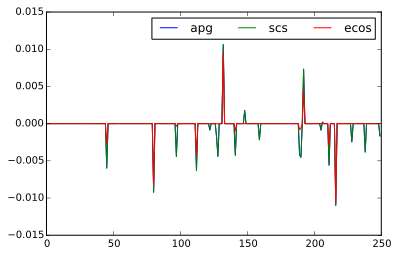

In [9]:
plt.plot(x, label='apg')
plt.plot(z_scs, label='scs')
plt.plot(z_ecos, label='ecos')
plt.legend(ncol=3)

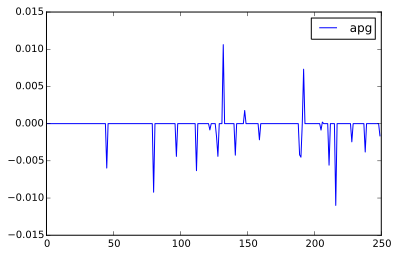

In [10]:
plt.plot(x, label='apg')
plt.legend()

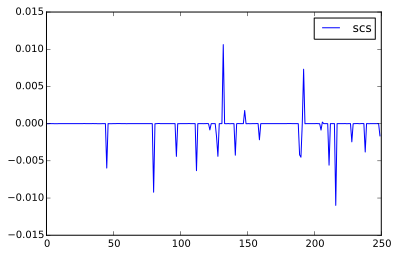

In [11]:
plt.plot(z_scs, label='scs')
plt.legend()

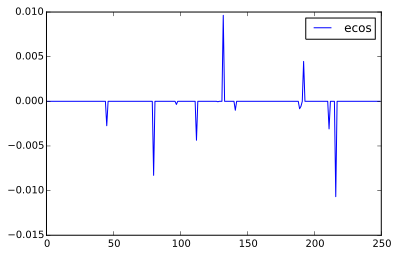

In [12]:
plt.plot(z_ecos, label='ecos')
plt.legend()